In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-reviews/winemag-data_first150k.csv
/kaggle/input/wine-reviews/winemag-data-130k-v2.json
/kaggle/input/wine-reviews/winemag-data-130k-v2.csv


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

# df = pd.read_csv('data/wine_data.csv')
df = pd.read_csv('/kaggle/input/wine-reviews/winemag-data_first150k.csv')

counter = Counter(df['variety'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}
df = df[df['variety'].map(lambda x: x in top_10_varieties)]

In [4]:
df.head()

Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
8           8      US  This re-named vineyard was formerly bottled as...   
9           9      US  The producer sources from two blocks of the vi...   

                     designation  points  price    province  \
0              Martha's Vineyard      96  235.0  California   
2  Special Selected Late Harvest      96   90.0  California   
3                        Reserve      96   65.0      Oregon   
8                         Silice      95   65.0      Oregon   
9           Gap's Crown Vineyard      95   60.0  California   

             region_1           region_2             variety     winery  
0         Napa Valley               Napa  Cabernet Sauvignon      Heitz  
2      Knights Valley             Sonoma     Sauvignon Blanc   Macauley  
3   Willamette Valley  Willamette Valley          Pinot Noir      Ponzi  
8  Chehalem Mountains  Willamette Valley          Pinot Noir  Bergström  
9        Sonoma Coast             Sonoma          Pinot Noir  Blue Farm

In [5]:
df = df.drop(['Unnamed: 0'],axis = 1)
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['variety'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(85520, 10)
Unique categories: 10
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85520 entries, 0 to 150912
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      85516 non-null  object 
 1   description  85520 non-null  object 
 2   designation  57934 non-null  object 
 3   points       85520 non-null  int64  
 4   price        79711 non-null  float64
 5   province     85516 non-null  object 
 6   region_1     72171 non-null  object 
 7   region_2     47885 non-null  object 
 8   variety      85520 non-null  object 
 9   winery       85520 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.2+ MB


In [6]:
# produce pandas profiling report
import pandas_profiling as pp
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

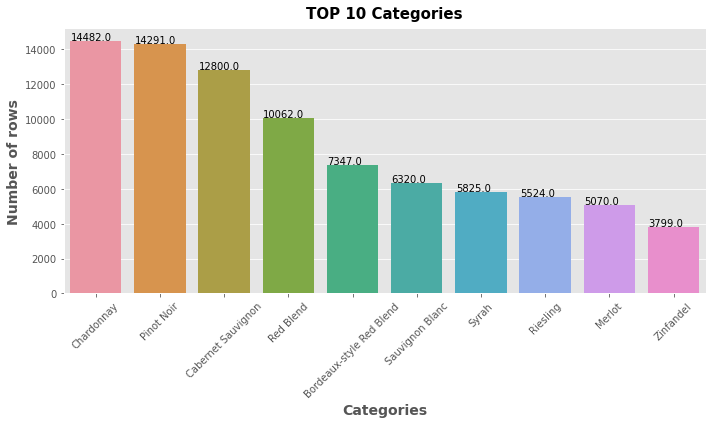

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['variety'].value_counts()).reset_index()
cat_df.rename(columns={'index':'variety','variety':'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.variety)[:10], np.array(cat_df.numcat)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 10 Categories", size=15)
plt.xlabel("Categories", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of rows", size=14)
plt.show()

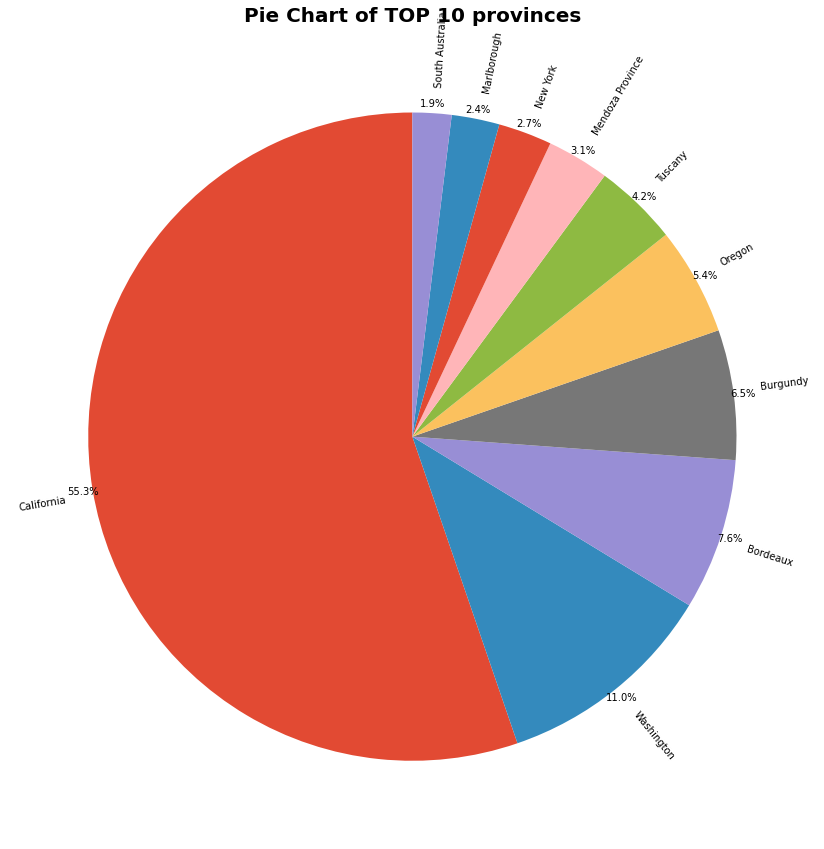

In [8]:
# plot the pie chart of top 10 provinces
cat_df = pd.DataFrame(df['province'].value_counts()).reset_index()
cat_df.rename(columns={'index':'province','province':'numcat'}, inplace=True)

fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:10],
            labels=cat_df['province'][:10],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 10 provinces", size=20, weight='bold')
plt.show()

(-0.5, 1599.5, 599.5, -0.5)

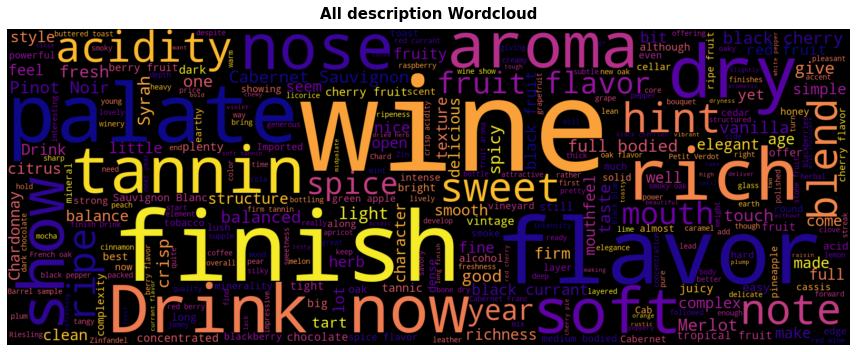

In [9]:
# wordcloud of varieties in our dataset
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df.description))

plt.title("All description Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

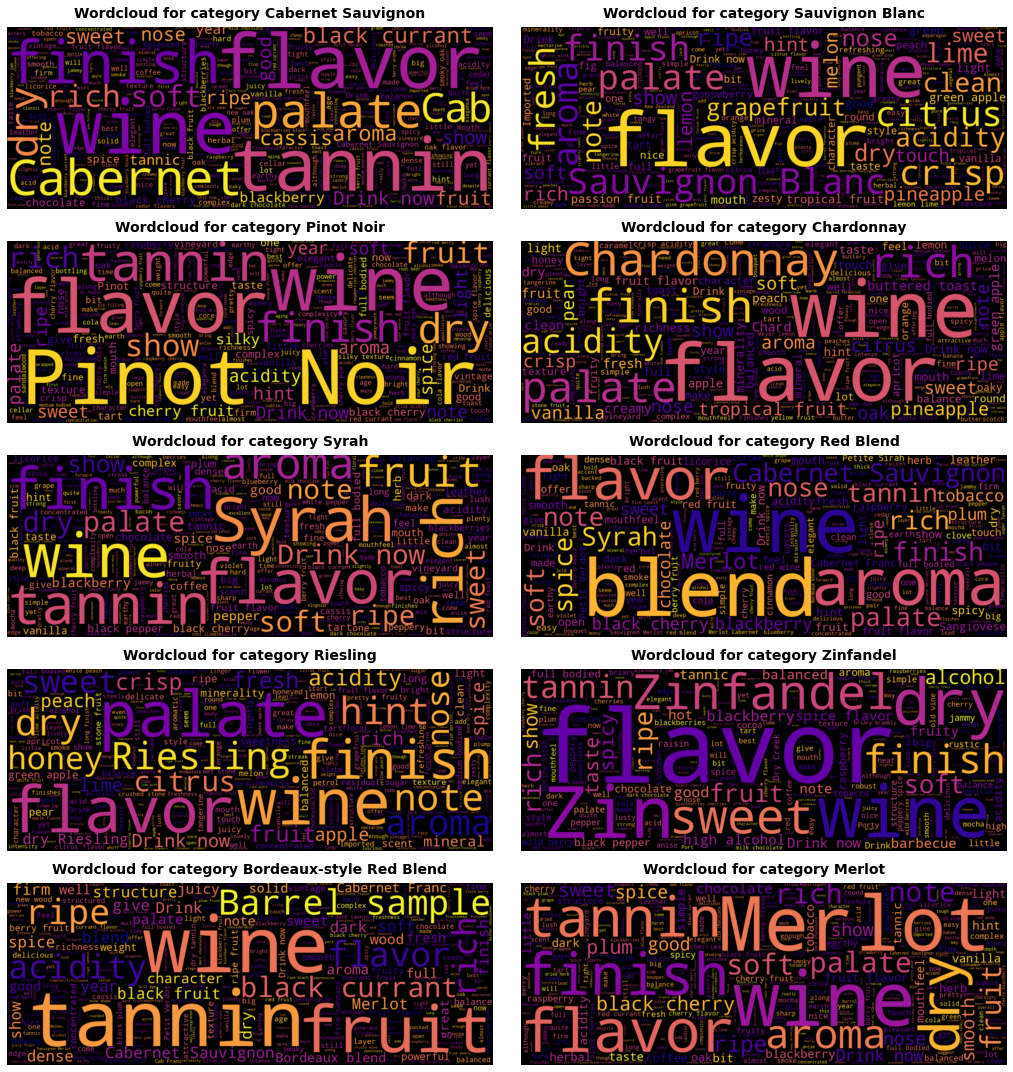

In [10]:
# create new dataframe 
ndf = df.copy()

# list of top 10 categories in out dataset
categories = df['variety'].unique()

# list of top 10 categories list
cat_list = []

for i in categories:
    cat_ndf = ndf[ndf['variety'] == i]
    cat_array = cat_ndf['description'].values  # array of news articles text in each category
    cat_list.append(cat_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(cat_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for category {j}")
    plt.axis('off')

In [11]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)

In [12]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf['description'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf['description'][0]))

Text sentence before pre-processing:
 This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 tremendous varietal wine hail oakville age three years oak juicy redcherry fruit compel hint caramel greet palate frame elegant fine tannins subtle minty tone background balance reward start finish years ahead develop nuance enjoy


In [13]:
df['description_clean'] = df['description'].map(lambda x: datacleaning(x))
description_list = df['description_clean'].tolist()
varietal_list = [top_10_varieties[i] for i in df['variety'].tolist()]
varietal_list = np.array(varietal_list)

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, varietal_list, test_size=0.3)

In [14]:
clf = MultinomialNB().fit(train_x, train_y)
#clf = SVC(kernel='linear').fit(train_x, train_y)
y_score = clf.predict(test_x)

n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Accuracy: 64.99%


In [15]:
from nltk import word_tokenize
from collections import defaultdict

def count_top_x_words(corpus, top_x, skip_top_n):
    count = defaultdict(lambda: 0)
    for c in corpus:
        for w in word_tokenize(c):
            count[w] += 1
    count_tuples = sorted([(w, c) for w, c in count.items()], key=lambda x: x[1], reverse=True)
    return [i[0] for i in count_tuples[skip_top_n: skip_top_n + top_x]]


def replace_top_x_words_with_vectors(corpus, top_x):
    topx_dict = {top_x[i]: i for i in range(len(top_x))}

    return [
        [topx_dict[w] for w in word_tokenize(s) if w in topx_dict]
        for s in corpus
    ], topx_dict


def filter_to_top_x(corpus, n_top, skip_n_top=0):
    top_x = count_top_x_words(corpus, n_top, skip_n_top)
    return replace_top_x_words_with_vectors(corpus, top_x)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
#from lib.get_top_xwords import filter_to_top_x

# df = pd.read_csv('data/wine_data.csv')
df = pd.read_csv('/kaggle/input/wine-reviews/winemag-data_first150k.csv')

counter = Counter(df['variety'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}
df = df[df['variety'].map(lambda x: x in top_10_varieties)]

df['description_clean'] = df['description'].map(lambda x: datacleaning(x))
description_list = df['description_clean'].tolist()

# description_list = df['description'].tolist()
mapped_list, word_list = filter_to_top_x(description_list, 2500, 10)
varietal_list_o = [top_10_varieties[i] for i in df['variety'].tolist()]
varietal_list = to_categorical(varietal_list_o)

max_review_length = 150

mapped_list = sequence.pad_sequences(mapped_list, maxlen=max_review_length)
train_x, test_x, train_y, test_y = train_test_split(mapped_list, varietal_list, test_size=0.3)

max_review_length = 150

embedding_vector_length = 64
model = Sequential()

model.add(Embedding(2500, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(50, 5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(max(varietal_list_o) + 1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5, batch_size=64)

y_score = model.predict(test_x)
y_score = [[1 if i == max(sc) else 0 for i in sc] for sc in y_score]
n_right = 0
for i in range(len(y_score)):
    if all(y_score[i][j] == test_y[i][j] for j in range(len(y_score[i]))):
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))

Epoch 1/5
936/936 [==============================] - 23s 23ms/step - loss: 0.9859 - accuracy: 0.6609
Epoch 2/5
936/936 [==============================] - 21s 23ms/step - loss: 0.5866 - accuracy: 0.8042
Epoch 3/5
936/936 [==============================] - 20s 22ms/step - loss: 0.4720 - accuracy: 0.8411
Epoch 4/5
936/936 [==============================] - 22s 23ms/step - loss: 0.3599 - accuracy: 0.8816
Epoch 5/5
936/936 [==============================] - 22s 23ms/step - loss: 0.2502 - accuracy: 0.9198
Accuracy: 82.99%
